# 필요한 라이브러리 임포트

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
import pandas as pd

# 전처리 함수 정의

In [2]:
# 문자 종류 확인
def build_vocab_from_df(df: pd.DataFrame):
    char_vocab = set()
    for line in df["msg"]:
        for c in line:
            char_vocab.add(c)
    return char_vocab

In [3]:
train = pd.read_csv("data/train.csv")
val = pd.read_csv("data/val.csv")
test = pd.read_csv("data/test.csv")

print("train:",train.shape)
print("val:",val.shape)
print("test:",test.shape)

train: (3618, 2)
val: (775, 2)
test: (776, 2)


### 문자 종류 갯수 확인

In [4]:
train_vocab = build_vocab_from_df(train)
val_vocab = build_vocab_from_df(val)
test_vocab = build_vocab_from_df(test)
print(len(train_vocab))
print(sorted(train_vocab))
print(len(val_vocab))
print(sorted(val_vocab))
print(len(test_vocab))
print(sorted(test_vocab))

print(set(test_vocab) - set(train_vocab))
print(set(val_vocab) - set(train_vocab))

94
[' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', '~', '£', '…']
88
[' ', '!', '"', '#', '$', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', '£', '…']
88
[' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/

## vocab 생성

In [5]:
char2idx = dict()
char2idx["pad"] = 0
char2idx["unk"] = 1
for index, char in enumerate(train_vocab):
    char2idx[char] = index + 2

idx2char = {value: key for key, value in char2idx.items()}
print(idx2char)
print("vocab size:", len(char2idx))

{0: 'pad', 1: 'unk', 2: 'S', 3: 'z', 4: 'b', 5: 'C', 6: 'W', 7: 'E', 8: '#', 9: '%', 10: '7', 11: 't', 12: 'F', 13: '$', 14: '9', 15: 'U', 16: 'R', 17: 'h', 18: '^', 19: '<', 20: '&', 21: 'M', 22: 'l', 23: 'o', 24: 'A', 25: '\\', 26: '(', 27: '~', 28: ']', 29: ':', 30: 'D', 31: '*', 32: 'x', 33: 'j', 34: 'K', 35: 'p', 36: 'e', 37: 'q', 38: '5', 39: 'X', 40: 'V', 41: 'u', 42: 'm', 43: '1', 44: '3', 45: 'T', 46: '0', 47: 'J', 48: 'a', 49: 'I', 50: ',', 51: '/', 52: ')', 53: 's', 54: '4', 55: '£', 56: 'y', 57: 'r', 58: 'H', 59: 'O', 60: '…', 61: 'Z', 62: '>', 63: "'", 64: 'f', 65: 'w', 66: '@', 67: ';', 68: '8', 69: 'c', 70: 'G', 71: '.', 72: 'P', 73: '[', 74: 'n', 75: '"', 76: 'Y', 77: 'g', 78: '2', 79: '!', 80: '-', 81: 'B', 82: '|', 83: ' ', 84: 'N', 85: 'Q', 86: 'v', 87: '_', 88: 'd', 89: 'L', 90: 'i', 91: 'k', 92: '+', 93: '?', 94: '=', 95: '6'}
vocab size: 96


In [6]:
seq_len = train["msg"].str.len().max()
input_length = len(char2idx)
print(seq_len)

199


# 커스텀 데이터셋 정의

In [7]:
class MyDataset(Dataset):
    def __init__(self, data=train):
        self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        x = self.data["msg"][idx]
        y = self.data["label"][idx]

        return x, y

# 토크나이저 정의

In [8]:
def tokenize(string: str):
    x_data = [char2idx[c] for c in string]
    return torch.tensor(x_data)

# Collate function 정의

In [9]:
def collate_fn(samples):
    x = [i[0] for i in samples]
    x = [tokenize(i) for i in x]
    x = pad_sequence(x, batch_first=True)
    
    y = [i[1] for i in samples]
    y = torch.tensor(y, dtype=torch.float32)

    return x, y

# RNN Cell과 모델 정의

In [10]:
class RNNCell_Encoder(nn.Module):
    def __init__(self, input_dim, hidden_size):
        super(RNNCell_Encoder, self).__init__()

        self.input_dim = input_dim
        self.hidden_size = hidden_size

        self.rnn = nn.RNNCell(input_dim, hidden_size)

    def forward(self, input):
        batch_size = input.size(0)
        ht = torch.zeros(batch_size, self.hidden_size)
        input = input.transpose(0, 1)
        for character in input:
            ht = self.rnn(character, ht)
        return ht

class Net(nn.Module):
    def __init__(self, embedding_dim, hidden_size):
        super(Net, self).__init__()

        self.em = nn.Embedding(len(char2idx), embedding_dim, padding_idx=0)  # 임베딩
        self.rnn = RNNCell_Encoder(embedding_dim, hidden_size)
        self.fc1 = nn.Linear(hidden_size, 10)
        self.fc2 = nn.Linear(10, 1)

    def forward(self, x):
        x = self.em(x)
        x = self.rnn(x)
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x

# 훈련

In [11]:
def training(epoch, model, loss_fn, optimizer, trainloader, valloader):
    correct = 0
    total = 0
    running_loss = 0
    flag = 1

    model.train()

    for x, y in trainloader:
        optimizer.zero_grad()
        y_pred = model(x)
        y = y.unsqueeze(1)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            y_pred = (y_pred > 0.5).float()
            correct += (y_pred == y).sum().item()
            total += y.size(0)
            running_loss += loss.item()

            # break        

    epoch_loss = running_loss / len(trainloader)
    epoch_acc = correct / total

    val_correct = 0
    val_total = 0
    val_running_loss = 0

    model.eval()
    with torch.no_grad():
        for x, y in valloader:
            y_pred = model(x)
            y = y.unsqueeze(1)
            loss = loss_fn(y_pred, y)
            y_pred = (y_pred > 0.5).float()
            val_correct += (y_pred == y).sum().item()
            val_total += y.size(0)
            val_running_loss += loss.item()

    epoch_val_loss = val_running_loss / len(valloader)
    epoch_val_acc = val_correct / val_total

    print(f"train_loss :{epoch_loss:.6f} train_acc :{epoch_acc:.6f} val_loss :{epoch_val_loss:.6f} val_acc :{epoch_val_acc:.6f}")

    return epoch_loss, epoch_acc, epoch_val_loss, epoch_val_acc

# 하이퍼파라미터 정의

In [17]:
model = Net(2, 80)

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
import time

train_ds = MyDataset(train)
val_ds = MyDataset(val)

epochs = 50
train_loss = []
train_acc = []
val_loss = []
val_acc = []

start = time.time()
for epoch in range(epochs):
    epoch_start = time.time()

    train_iterator = iter(
        DataLoader(train_ds, batch_size=512, shuffle=True, collate_fn=collate_fn)
    )
    val_iterator = iter(
        DataLoader(val_ds, batch_size=64, shuffle=True, collate_fn=collate_fn)
    )

    epoch_loss, epoch_acc, epoch_val_loss, epoch_val_acc = training(
        epoch, model, loss_fn, optimizer, train_iterator, val_iterator
    )

    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    val_loss.append(epoch_val_loss)
    val_acc.append(epoch_val_acc)

    epoch_end = time.time()
    print(f"epoch {epoch} finished in {epoch_end-epoch_start:.2f} seconds")

end = time.time()
print(f"train_loss :{sum(train_loss)/epochs:.6f}\
      train_acc :{sum(train_acc)/epochs:.6f}\
        val_loss :{sum(val_loss)/epochs:.6f}\
        val_acc :{sum(val_acc)/epochs:.6f}")

print(f"training finished in {end-start:.2f} seconds")

train_loss :0.666946 train_acc :0.662797 val_loss :0.601294 val_acc :0.873548
epoch 0 finished in 2.51 seconds
train_loss :0.507780 train_acc :0.873687 val_loss :0.414185 val_acc :0.873548
epoch 1 finished in 2.23 seconds
train_loss :0.376004 train_acc :0.873687 val_loss :0.414449 val_acc :0.873548
epoch 2 finished in 1.81 seconds
train_loss :0.388312 train_acc :0.873687 val_loss :0.367531 val_acc :0.873548
epoch 3 finished in 1.37 seconds
train_loss :0.394301 train_acc :0.873687 val_loss :0.419987 val_acc :0.873548
epoch 4 finished in 1.33 seconds
train_loss :0.390213 train_acc :0.873687 val_loss :0.401020 val_acc :0.873548
epoch 5 finished in 1.31 seconds
train_loss :0.368630 train_acc :0.873687 val_loss :0.417593 val_acc :0.873548
epoch 6 finished in 1.33 seconds
train_loss :0.356692 train_acc :0.873687 val_loss :0.362745 val_acc :0.873548
epoch 7 finished in 1.30 seconds
train_loss :0.386378 train_acc :0.873687 val_loss :0.363101 val_acc :0.873548
epoch 8 finished in 1.31 seconds
t

In [29]:
import matplotlib.pyplot as plt
def plot_metrics(train_acc, train_loss, val_acc, val_loss):
    epochs = range(1, len(train_acc) + 1)

    # Plotting accuracy
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting loss
    plt.subplot(2, 1, 2)
    plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

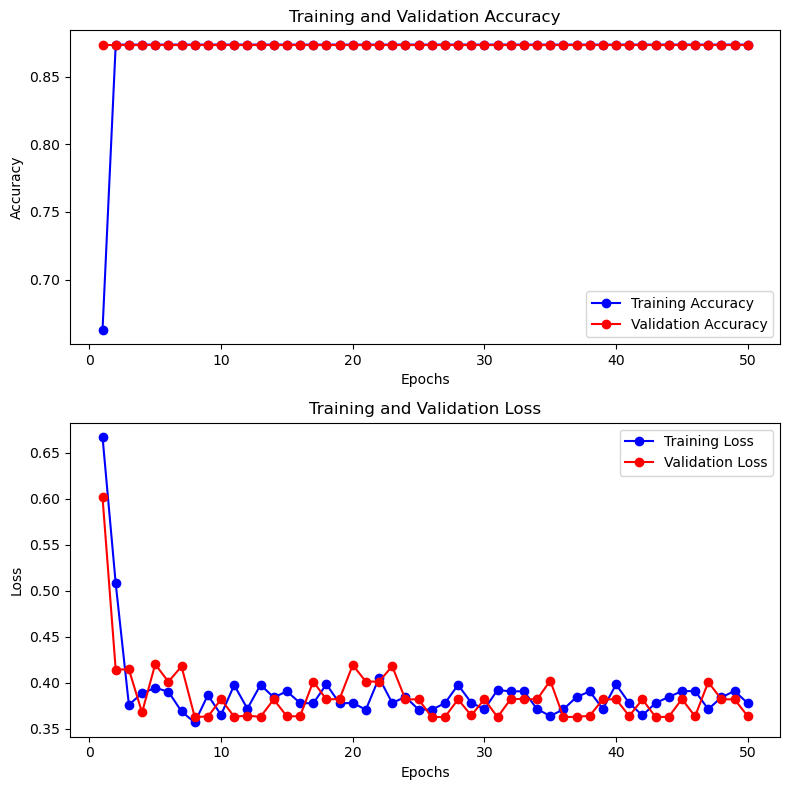

In [30]:
plot_metrics(train_acc, train_loss, val_acc, val_loss)

# 테스트

In [ ]:
test_ds = MyDataset(test)
test_iterator = iter(DataLoader(test_ds, batch_size=10, collate_fn=collate_fn))

test_correct = 0
test_total = 0
test_loss = 0

model.eval()
with torch.no_grad():
    for x, y in test_iterator:
        y_pred = model(x)
        y = y.unsqueeze(1)
        loss = loss_fn(y_pred, y)
    
        y_pred = (y_pred > 0.5).float()
        test_correct += (y_pred == y).sum().item()
        test_total += y.size(0)
        test_loss += loss.item()

test_loss = test_loss / len(test_iterator)
test_acc = test_correct / test_total
print(f'test loss: {test_loss}\
      test accuracy: {test_acc}')

test loss: 0.3907663506957201      test accuracy: 0.8737113402061856


# 결과 해석

In [ ]:
(test["label"] == 0).sum() / test.shape[0]

0.8737113402061856

모든 데이터포인트에 대해 ham을 예측했다. 
이는 문자 레벨 토큰화로 인해 너무 길어진 시퀀스 길이가 문제일 것으로 생각한다.